In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories

from src.python.models import MainSimulator

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

In [3]:
RNG = np.random.default_rng()

# Model formulation

We define stimulus type and response as
- 0 = "new"
- 1 = "old".

## Signal-detection model

Hyperpriors:
$$
\begin{align}
\mu_{h'} &\sim \mathcal{N}(0, 1) \\
\sigma_{h'} &\sim \textrm{Gamma}(1, 1)\\
\mu_{f'} &\sim \mathcal{N}(0, 1)\\
\sigma_{f'} &\sim \textrm{Gamma}(1, 1)\\
\end{align}
$$
Group-level model:
$$
\begin{align}
h_m' &\sim \mathcal{N}(\mu_{h'}, \sigma_{h'}) \text{ for } m=1,\dots,M\\
f_m' &\sim \mathcal{N}(\mu_{f'}, \sigma_{f'}) \text{ for } m=1,\dots,M\\
h_m &= \Phi(h_m') \text{ for } m=1,\dots,M\\
f_m &= \Phi(f_m') \text{ for } m=1,\dots,M\\
\end{align}
$$
Observation-level model:
$$
\begin{align}
x_n^{h}|h_m &\sim \textrm{Bin}(O_m, h_m) \text{ for } n=1,\dots,N_m\\
x_n^{f}|f_m &\sim \textrm{Bin}(W_m, f_m) \text{ for } n=1,\dots,N_m
\end{align}
$$

$\Phi =$ Standard normal cumulative distribution function

$h_m' = \Phi^{-1}(h_m) =$ probit-transformed hit probability (on old items)

$f_m' = \Phi^{-1}(f_m) =$ probit-transformed false alarm probability (on new items)

$O_m =$ Number of old/signal trials per participant m

$W_m =$ Number of new/noise trials per participant m

[Notation follows Rouder & Lu (2005)]

[Priors are informed by the results of Greene, Martin & Naveh-Benjamin (2021)]

## MPT model (Latent-trait 2HTM)

Hyperpriors:
$$
\begin{align}
\mu_{d'} &\sim \mathcal{N}(0, 1) \\
\mu_{g'} &\sim \mathcal{N}(0, 1) \\
\lambda_p &\sim \textrm{Uniform}(0, 10) \text{ for } p= d', g'\\
Q &\sim InvWishart(\mathbb{I}, P+1)\\
\Sigma &= \textrm{Diag}(\lambda_p) Q \textrm{Diag}(\lambda_p)\\
\end{align}
$$
Group-level model:
$$
\begin{align}
\left[ \begin{array}{l} d_m' \\ g_m' \end{array} \right] 
&\sim \mathcal{N} \left( 
\left[\begin{array}{l} \mu_{d'} \\ \mu_{g'} \end{array} \right], \Sigma
\right) \text{ for } m=1,\dots,M\\

d_m &= \Phi(d_m') \text{ for } m=1,\dots,M\\
g_m &= \Phi(g_m') \text{ for } m=1,\dots,M\\
h_m &= d_m + (1-d_m)*g_m \text{ for } m=1,\dots,M\\
f_m &= (1-d_m)*g_m \text{ for } m=1,\dots,M\\
\end{align}
$$
Observation-level model:
$$
\begin{align}
x_n^{h}|h_m &\sim \textrm{Bin}(O_m, h_m) \text{ for } n=1,\dots,N_m\\
x_n^{f}|f_m &\sim \textrm{Bin}(W_m, f_m) \text{ for } n=1,\dots,N_m
\end{align}
$$

Restriction: $d_O = d_W$

$\Phi =$ Standard normal cumulative distribution function

$h_m' = \Phi^{-1}(h_m) =$ probit-transformed hit probability (on old items)

$f_m' = \Phi^{-1}(f_m) =$ probit-transformed false alarm probability (on new items)

$O_m =$ Number of old/signal trials per participant m

$W_m =$ Number of new/noise trials per participant m

[Notation follows Klauer(2010)]

[Prior choices are informed by Gronau, Wagenmakers & Heck (2019)]

# Simulator

In [4]:
class HierarchicalSdtMptSimulator:

    def __init__(self):
        pass

    def draw_from_prior(self, model_index, n_clusters):
        """ Draws parameter values from the specified prior distributions of the hyperprior and the conditional prior.

        Parameters
        ----------
        model_index : int
            Index of the model to be simulated from.
        n_clusters : int
            Number of higher order clusters that the observations are nested in.

        Returns
        -------
        p_h_m : np.array
            Hit probability per cluster.
        p_h_m : np.array
            False alarm probability per cluster.
        """

        if model_index == 0: # SDT model

            # Hyperpriors
            mu_h = RNG.normal(0.5, 1)
            sigma_h = RNG.gamma(1, 1)
            mu_f = RNG.normal(-1, 1)
            sigma_f = RNG.gamma(1, 1)

            # Group-level priors
            h_m = RNG.normal(loc=mu_h, scale=sigma_h, size=n_clusters)
            f_m = RNG.normal(loc=mu_f, scale=sigma_f, size=n_clusters)

            # Transform probit-transformed parameters to probabilities
            p_h_m = stats.norm.cdf(h_m) 
            p_f_m = stats.norm.cdf(f_m)

        if model_index == 1: # MPT model

            # Hyperpriors
            mu_d = RNG.normal(0, 1)
            mu_g = RNG.normal(0, 1)
            lambdas = RNG.uniform(0, 10, size=2)
            Q = stats.invwishart.rvs(df=3, scale=np.identity(2))
            sigma = np.matmul(np.matmul(np.diag(lambdas), Q), np.diag(lambdas))

            # Group-level priors
            params = RNG.multivariate_normal([mu_d, mu_g], sigma, size=n_clusters)
            d_m = params[:, 0]
            g_m = params[:, 1]
            p_d_m = stats.norm.cdf(d_m) # Transform probit-transformed parameters to probabilities
            p_g_m = stats.norm.cdf(g_m) # Transform probit-transformed parameters to probabilities
            p_h_m = p_d_m + (1-p_d_m)*p_g_m
            p_f_m = (1-p_d_m)*p_g_m
        
        return p_h_m, p_f_m

    def generate_from_likelihood(self, p_h_m, p_f_m, n_clusters, n_obs):
        """ Generates a single hierarchical data set from the sampled parameter values.

        Parameters
        ----------
        p_h_m : np.array
            Hit probability per cluster.
        p_h_m : np.array
            False alarm probability per cluster.
        n_clusters : int
            Number of higher order clusters that the observations are nested in.
        n_obs : int
            Number of observations per cluster.

        Returns
        -------
        X : np.array
            Generated data set with shape (n_clusters, n_obs, 2).
            Contains 2 binary variables with stimulus type and response (for both applies: 0="new" / 1="old").
        """

        # Determine amount of signal (old item) and noise (new item) trials
        assert n_obs%2 == 0, "n_obs has to be dividable by 2."
        n_trials_per_cat = int(n_obs/2)

        # Create stimulus types (0="new" / 1="old")
        stim_cluster = np.repeat([[1,0]], repeats=n_trials_per_cat, axis=1) # for 1 participant
        stim_data_set = np.repeat(stim_cluster, repeats=n_clusters, axis=0) # for 1 data set

        # Create individual responses (0="new" / 1="old")
        X_h = RNG.binomial(n=1, p=p_h_m, size=(n_trials_per_cat, n_clusters)).T # Old items
        X_f = RNG.binomial(n=1, p=p_f_m, size=(n_trials_per_cat, n_clusters)).T # New items
        X_responses = np.concatenate((X_h, X_f), axis=1)

        # Create final data set
        X = np.stack((stim_data_set, X_responses), axis=2)

        return X

    def generate_single(self, model_index, n_clusters, n_obs):
        """Generates a single hierarchical data set utilizing the draw_from_prior and gen_from_likelihood functions.

        Parameters
        ----------
        model_index : int
            Index of the model to be simulated from.
        n_clusters : int
            Number of higher order clusters that the observations are nested in.
        n_obs : int
            Number of observations per cluster.

        Returns
        -------
        X : np.array
            Generated data set with shape (n_clusters, n_obs, 2).
            Contains 2 binary variables with stimulus type and response (for both applies: 0="new" / 1="old").
        """

        p_h_m, p_f_m = self.draw_from_prior(model_index, n_clusters)
        X = self.generate_from_likelihood(p_h_m, p_f_m, n_clusters, n_obs)

        return X

In [5]:
# Test class for single data set
simulator_single = HierarchicalSdtMptSimulator()
simulator_single.generate_single(model_index=1, n_clusters=100, n_obs=50).mean()

0.519

In [6]:
# Test class for batch of data sets
def n_clust_obs():
    """
    Nasty hack to make compatible with BayesFlow.
    Defines a fixed number of clusters and observations.
    """
    
    M = 50
    N = 50
    return (M, N)

simulator = MainSimulator(HierarchicalSdtMptSimulator())
m_sim, _, x_sim = simulator(batch_size=5000, n_obs=n_clust_obs(), n_vars=2)
sim_data = {'X' : x_sim, 'm' : m_sim}

sim_data['X']

array([[[[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        ...,

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         ...,
         [0., 0.],
         [0., 1.],
         [0., 0.]]],


       [[[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[1., 0.],
         [1., 1.],
         [1., 1.],
         ...,
   

## Prior predictive checks

### Parameter distributions

In [14]:
# Simulate data

simulator = MainSimulator(HierarchicalSdtMptSimulator())

n_data_sets = 5000
n_clusters = 100
n_obs = 50

def n_clust_obs():
    """
    Nasty hack to make compatible with BayesFlow.
    Defines a fixed number of clusters and observations.
    """
    
    M = n_clusters
    N = n_obs
    return (M, N)

m_sim, _, x_sim = simulator(batch_size=n_data_sets, n_obs=n_clust_obs(), n_vars=2)
sim_data = {'X' : x_sim, 'm' : m_sim}

In [15]:
# Split data by underlying model
data_sdt = sim_data['X'][sim_data['m'][:, 1] == 0,:,:,:]
data_mpt = sim_data['X'][sim_data['m'][:, 1] == 1,:,:,:]

In [16]:
# SDT model

# Split by item type
data_sdt_old_items = np.reshape(data_sdt[data_sdt[:,:,:,0] == 1], (data_sdt.shape[0], n_clusters, n_obs))
data_sdt_new_items = np.reshape(data_sdt[data_sdt[:,:,:,0] == 0], (data_sdt.shape[0], n_clusters, n_obs))

# Compute hit rate and false alarm rate
data_sdt_hit_rate = np.mean(data_sdt_old_items, axis=(0,2))
data_sdt_fa_rate = np.mean(data_sdt_new_items, axis=(0,2))

In [17]:
# MPT model

# Split by item type
data_mpt_old_items = np.reshape(data_mpt[data_mpt[:,:,:,0] == 1], (data_mpt.shape[0], n_clusters, n_obs))
data_mpt_new_items = np.reshape(data_mpt[data_mpt[:,:,:,0] == 0], (data_mpt.shape[0], n_clusters, n_obs))

# Compute hit rate and false alarm rate
data_mpt_hit_rate = np.mean(data_mpt_old_items, axis=(0,2))
data_mpt_fa_rate = np.mean(data_mpt_new_items, axis=(0,2))

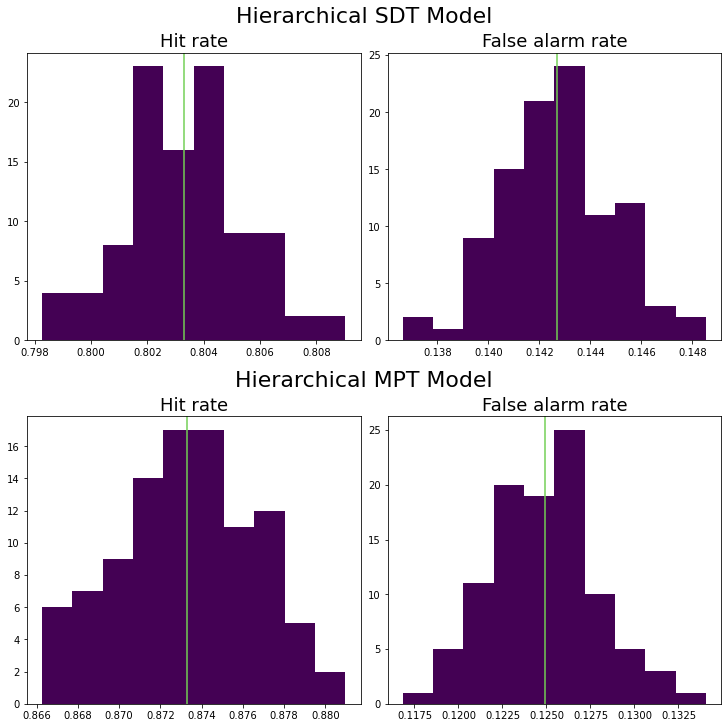

In [18]:
# Plot person means

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
subfigs = fig.subfigures(nrows=2, ncols=1)
subfigure_titles = ['Hierarchical SDT Model', 'Hierarchical MPT Model']

hit_rate_list = [data_sdt_hit_rate, data_mpt_hit_rate]
fa_rate_list = [data_sdt_fa_rate, data_mpt_fa_rate]

# Use subfig to enable row titles
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigure_titles[row], fontsize=22)

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)

    axs[0].hist(hit_rate_list[row], color='#440154FF')
    axs[0].set_title('Hit rate', fontsize=18)
    axs[0].axvline(np.mean(hit_rate_list[row]), color='#73D055FF')
    axs[1].hist(fa_rate_list[row], color='#440154FF')
    axs[1].set_title('False alarm rate', fontsize=18)
    axs[1].axvline(np.mean(fa_rate_list[row]), color='#73D055FF')